**Carl Cook**

# Introduction

In this notebook, we'll look at data provided in the King County Housing Database to create a multiple linear regression model. This model will allow us to estimate the price of homes based on features such as square footage and location.

Which features of contribute the most to a home's value? Which ones can we safely ignore? Which features muddle our interpretation? This notebook will use the OSEMN workflow process to take us step-by-step toward finding these answers.

# Obtain

## Load the .csv into a DataFrame

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
%matplotlib inline
plt.style.use('seaborn')

In [3]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### Scatter Matrix

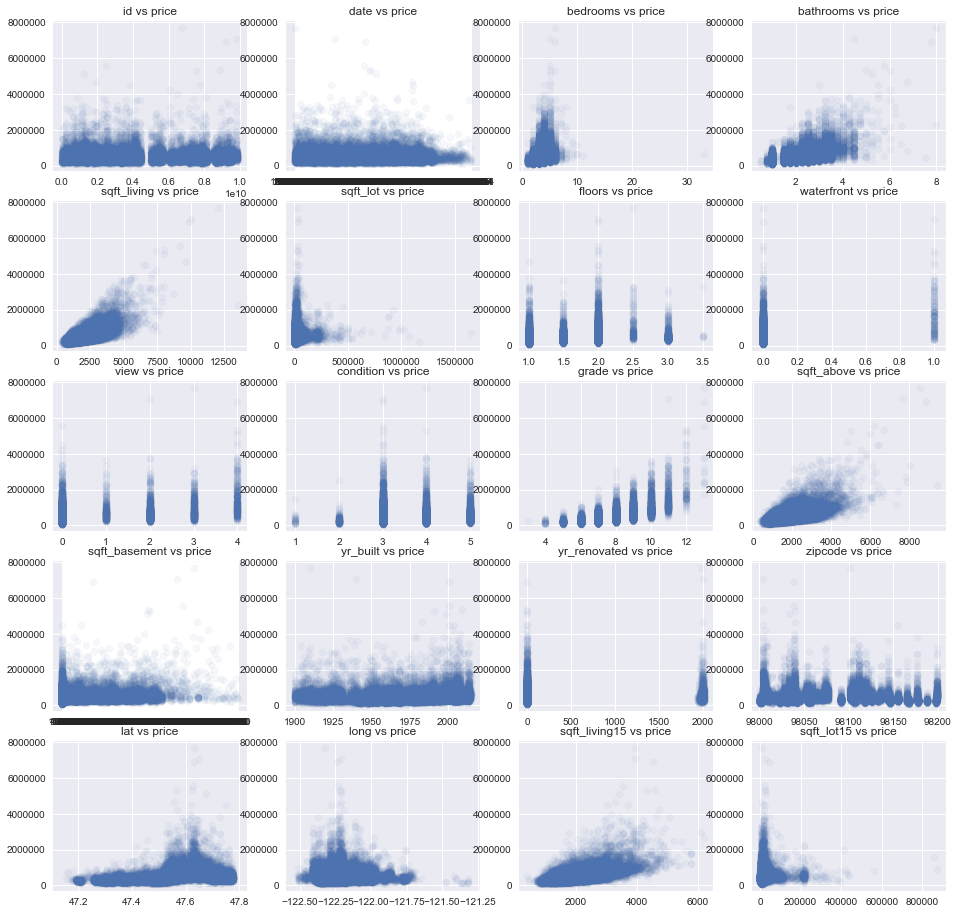

In [4]:
pred_cols = [col for col in df.columns if col != 'price']
fig, axes = plt.subplots(5,4, figsize=(16,16))
for i,col in enumerate(pred_cols):
    axes[i//4,i%4].scatter(col, 'price', data=df, alpha=.05)
    axes[i//4,i%4].set_title(f'{col} vs price')
plt.show()

# Scrub

## Deal with null values

In [5]:
for col in pred_cols:
    print(f'{col}: {df[col].isna().sum()}')

id: 0
date: 0
bedrooms: 0
bathrooms: 0
sqft_living: 0
sqft_lot: 0
floors: 0
waterfront: 2376
view: 63
condition: 0
grade: 0
sqft_above: 0
sqft_basement: 0
yr_built: 0
yr_renovated: 3842
zipcode: 0
lat: 0
long: 0
sqft_living15: 0
sqft_lot15: 0


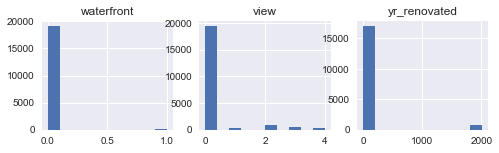

In [6]:
# Histogram of all columns containing null values
nulls = []
for col in pred_cols:
    if df[col].isna().sum() > 0:
        nulls.append(col)

fig,ax = plt.subplots(1,len(nulls),figsize=(8,2))
for i,col in enumerate(nulls):
    ax[i].hist(df[col].dropna())
    ax[i].set_title(col)
plt.show()

It looks like the columns with NaN values are heavy on zeros, so we'll just replace all NaN with 0.

### 'sqft_basement'
Some '?' values for this column, but all values seem intact for 'sqft_living' and 'sqft_above', so we'll just use those values to calculate new values for 'sqft_basement'.

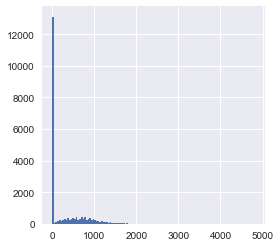

In [178]:
df.sqft_basement.hist(bins='auto', figsize=(4,4))

Looks like the real question is whether or not a house has a basement, so let's use this information to make a new 'basement' column.

In [179]:
df['basement'] = [1 if x > 0 else 0 for x in df['sqft_basement']]
df = df.drop(columns='sqft_basement')

In [180]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,1955,0.0,98178,47.5112,-122.257,1340,5650,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,1951,1991.0,98125,47.7210,-122.319,1690,7639,1
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,1933,0.0,98028,47.7379,-122.233,2720,8062,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,1965,0.0,98136,47.5208,-122.393,1360,5000,1
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,1987,0.0,98074,47.6168,-122.045,1800,7503,0


## yr_renovated

In [181]:
df['yr_renovated'].value_counts()

0.0       20853
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

Most homes haven't been renovated, so we'll just do what we did with the basement column.

In [182]:
df['renovated'] = [1 if x > 0 else 0 for x in df['yr_renovated']]
df = df.drop(columns='yr_renovated')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,1955,98178,47.5112,-122.257,1340,5650,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,1951,98125,47.7210,-122.319,1690,7639,1,1
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,1933,98028,47.7379,-122.233,2720,8062,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,1965,98136,47.5208,-122.393,1360,5000,1,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,1987,98074,47.6168,-122.045,1800,7503,0,0


## yr_built

Let's use yr_built to make an 'age' column.

In [183]:
yr_sold = list(map(int, [x.split('/')[2] for x in df['date']]))
df['age'] = [int((yr_sold[i]) - df['yr_built'][i]) for i in range(len(df['yr_built']))]

In [184]:
df['age'].value_counts()

 9      472
 8      443
 11     431
 0      430
 10     428
       ... 
 113     28
 115     26
 81      23
 80      21
-1       12
Name: age, Length: 117, dtype: int64

Let's fix those negative values.

In [185]:
df['age'] = [x if x > 0 else 0 for x in df['age']]

In [186]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated,age
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1180,1955,98178,47.5112,-122.257,1340,5650,0,0,59
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,1951,98125,47.7210,-122.319,1690,7639,1,1,63
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,770,1933,98028,47.7379,-122.233,2720,8062,0,0,82
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,1965,98136,47.5208,-122.393,1360,5000,1,0,49
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1680,1987,98074,47.6168,-122.045,1800,7503,0,0,28


## Outliers

Now let's get into the numerical columns to look for outliers.

In [192]:
df_num = df.drop(columns=['id', 'date', 'waterfront', 'zipcode', 'basement', 'renovated'])

In [193]:
columns = df_num.columns
# check z-scores to find outliers in each column
for col in columns:
    z = np.abs(stats.zscore(df_num[col]))
    num_ol = (z > 3).sum()
    print(f'{col}: {num_ol} outliers')

price: 406 outliers
bedrooms: 61 outliers
bathrooms: 187 outliers
sqft_living: 248 outliers
sqft_lot: 346 outliers
floors: 7 outliers
view: 825 outliers
condition: 29 outliers
grade: 130 outliers
sqft_above: 253 outliers
yr_built: 0 outliers
lat: 0 outliers
long: 232 outliers
sqft_living15: 236 outliers
sqft_lot15: 363 outliers
age: 0 outliers


* 'view' has a lot of outliers. Let's look into it.

In [194]:
df_num.view.value_counts()

0    19485
2      957
3      508
1      330
4      317
Name: view, dtype: int64

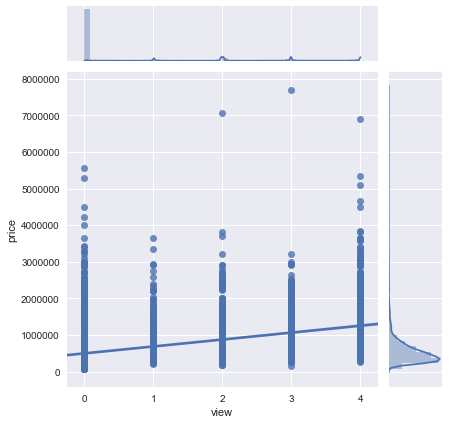

In [195]:
sns.jointplot(df.view, df.price, kind='reg')

I'm still not sure what 'view' even represents, so I think I'll just drop the column and go from there.

In [196]:
df_num = df_num.drop(columns='view')

columns = df_num.columns
# check z-scores to find outli
for col in columns:
    z = np.abs(stats.zscore(df_num[col]))
    num_ol = (z > 3).sum()
    print(f'{col}: {num_ol} outliers')

price: 406 outliers
bedrooms: 61 outliers
bathrooms: 187 outliers
sqft_living: 248 outliers
sqft_lot: 346 outliers
floors: 7 outliers
condition: 29 outliers
grade: 130 outliers
sqft_above: 253 outliers
yr_built: 0 outliers
lat: 0 outliers
long: 232 outliers
sqft_living15: 236 outliers
sqft_lot15: 363 outliers
age: 0 outliers


Lets' record all those z-scores!

New DataFrame with outliers removed.

In [199]:
df_olr = df[(z < 3).all(axis=1)]

In [200]:
df_olr.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated,age
0,7129300520,10/13/2014,221900,3,1.00,1180,5650,1.0,0,0,...,1180,1955,98178,47.5112,-122.257,1340,5650,0,0,59
1,6414100192,12/9/2014,538000,3,2.25,2570,7242,2.0,0,0,...,2170,1951,98125,47.7210,-122.319,1690,7639,1,1,63
2,5631500400,2/25/2015,180000,2,1.00,770,10000,1.0,0,0,...,770,1933,98028,47.7379,-122.233,2720,8062,0,0,82
3,2487200875,12/9/2014,604000,4,3.00,1960,5000,1.0,0,0,...,1050,1965,98136,47.5208,-122.393,1360,5000,1,0,49
4,1954400510,2/18/2015,510000,3,2.00,1680,8080,1.0,0,0,...,1680,1987,98074,47.6168,-122.045,1800,7503,0,0,28
6,1321400060,6/27/2014,257500,3,2.25,1715,6819,2.0,0,0,...,1715,1995,98003,47.3097,-122.327,2238,6819,0,0,19
7,2008000270,1/15/2015,291850,3,1.50,1060,9711,1.0,0,0,...,1060,1963,98198,47.4095,-122.315,1650,9711,0,0,52
8,2414600126,4/15/2015,229500,3,1.00,1780,7470,1.0,0,0,...,1050,1960,98146,47.5123,-122.337,1780,8113,1,0,55
9,3793500160,3/12/2015,323000,3,2.50,1890,6560,2.0,0,0,...,1890,2003,98038,47.3684,-122.031,2390,7570,0,0,12
10,1736800520,4/3/2015,662500,3,2.50,3560,9796,1.0,0,0,...,1860,1965,98007,47.6007,-122.145,2210,8925,1,0,50


In [201]:
pr = (len(df) - len(df_olr))/len(df)
print(f'{len(df)} original rows.')
print(f'{len(df_olr)} rows remaining.')
print(f'{round(pr*100,2)} percent data removed.')

21597 original rows.
20099 rows remaining.
6.94 percent data removed.


Resetting our DataFrame with just the data we want.

In [202]:
df = df_olr.drop(columns=['view', 'date', 'yr_built'])
df.reset_index(drop=True, inplace=True)

## Normalize Data

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20099 entries, 0 to 20098
Data columns (total 19 columns):
id               20099 non-null int64
price            20099 non-null int64
bedrooms         20099 non-null int64
bathrooms        20099 non-null float64
sqft_living      20099 non-null int64
sqft_lot         20099 non-null int64
floors           20099 non-null float64
waterfront       20099 non-null int64
condition        20099 non-null int64
grade            20099 non-null int64
sqft_above       20099 non-null int64
zipcode          20099 non-null int64
lat              20099 non-null float64
long             20099 non-null float64
sqft_living15    20099 non-null int64
sqft_lot15       20099 non-null int64
basement         20099 non-null int64
renovated        20099 non-null int64
age              20099 non-null int64
dtypes: float64(4), int64(15)
memory usage: 2.9 MB


In [204]:
# cols_to_norm = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
#                'floors', 'condition', 'grade', 'sqft_above',
#                'lat', 'long', 'sqft_living15', 'sqft_lot15', 'age']
cols_to_norm = ['price', 'sqft_living', 'sqft_lot', 'sqft_above',
                'lat', 'long', 'sqft_living15', 'sqft_lot15', 'age']

In [205]:
df[cols_to_norm].head()

,price,sqft_living,sqft_lot,sqft_above,lat,long,sqft_living15,sqft_lot15,age
0,221900,1180,5650,1180,47.5112,-122.257,1340,5650,59
1,538000,2570,7242,2170,47.7210,-122.319,1690,7639,63
2,180000,770,10000,770,47.7379,-122.233,2720,8062,82
3,604000,1960,5000,1050,47.5208,-122.393,1360,5000,49
4,510000,1680,8080,1680,47.6168,-122.045,1800,7503,28


In [206]:
df[cols_to_norm].describe()

,price,sqft_living,sqft_lot,sqft_above,lat,long,sqft_living15,sqft_lot15,age
count,2.009900e+04,20099.000000,20099.000000,20099.000000,20099.000000,20099.000000,20099.000000,20099.000000,20099.000000
mean,4.977444e+05,1982.390268,9997.249117,1703.957461,47.561121,-122.224137,1927.696552,9202.473058,43.964376
std,2.485159e+05,759.911198,11645.874396,705.046175,0.139247,0.128702,608.811143,9095.398497,29.369593
min,8.200000e+04,370.000000,520.000000,370.000000,47.176400,-122.512000,460.000000,651.000000,0.000000
25%,3.170000e+05,1410.000000,5000.000000,1180.000000,47.471550,-122.332000,1470.000000,5000.000000,18.000000
50%,4.400000e+05,1870.000000,7400.000000,1520.000000,47.572900,-122.246000,1810.000000,7470.000000,41.000000
75%,6.200000e+05,2450.000000,10000.000000,2110.000000,47.680100,-122.138500,2290.000000,9656.500000,63.000000
max,1.640000e+06,4790.000000,137214.000000,4270.000000,47.777600,-121.797000,4042.000000,93825.000000,115.000000


### Normalize

In [207]:
temp_df = df.loc[:, cols_to_norm]
temp_df = (temp_df - temp_df.mean()) / temp_df.std()

In [208]:
temp_df.head()

,price,sqft_living,sqft_lot,sqft_above,lat,long,sqft_living15,sqft_lot15,age
0,-1.109967,-1.055900,-0.373287,-0.743153,-0.358509,-0.255345,-0.965318,-0.390579,0.511945
1,0.161984,0.773261,-0.236586,0.661010,1.148171,-0.737079,-0.390427,-0.171897,0.648141
2,-1.278567,-1.595437,0.000236,-1.324676,1.269538,-0.068867,1.301394,-0.125390,1.295068
3,0.427561,-0.029464,-0.429100,-0.927538,-0.289567,-1.312053,-0.932467,-0.462044,0.171457
4,0.049315,-0.397928,-0.164629,-0.033980,0.399858,1.391876,-0.209747,-0.186850,-0.543568


In [210]:
df_norm = df.copy()
df_norm.loc[:, cols_to_norm] = temp_df
df_norm.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated,age
0,7129300520,-1.109967,3,1.00,-1.055900,-0.373287,1.0,0,3,7,-0.743153,98178,-0.358509,-0.255345,-0.965318,-0.390579,0,0,0.511945
1,6414100192,0.161984,3,2.25,0.773261,-0.236586,2.0,0,3,7,0.661010,98125,1.148171,-0.737079,-0.390427,-0.171897,1,1,0.648141
2,5631500400,-1.278567,2,1.00,-1.595437,0.000236,1.0,0,3,6,-1.324676,98028,1.269538,-0.068867,1.301394,-0.125390,0,0,1.295068
3,2487200875,0.427561,4,3.00,-0.029464,-0.429100,1.0,0,5,7,-0.927538,98136,-0.289567,-1.312053,-0.932467,-0.462044,1,0,0.171457
4,1954400510,0.049315,3,2.00,-0.397928,-0.164629,1.0,0,3,8,-0.033980,98074,0.399858,1.391876,-0.209747,-0.186850,0,0,-0.543568


## One-Hot Encode Categoricals

### zipcode

In [213]:
# Thanks to Chris for this lovely dictionary!

subregion_dict = {'south_urban': [98001, 98002, 98003, 98023, 98030, 98031, 98032, 98042, 
                                 98055, 98056, 98058, 98092, 98148, 98166, 98168, 98178, 98188,
                                 98198], 
                 'east_urban' : [98004, 98005, 98006, 98007, 98008, 98009, 98027, 98029, 
                                 98033, 98034, 98039, 98040, 98052, 98053, 98059, 98074, 
                                98075, 98077],
                 'south_rural' : [98010, 98022, 98038],
                 'north' : [98011, 98028, 98072, 98155],
                 'east_rural' : [98014, 98019, 98024, 98045, 98065],
                 'vashon_island' : [98070], 
                 'seattle' : [98102, 98103, 98105, 98106, 98107, 98108, 98109, 98112, 98115,
                             98116, 98117, 98118, 98119, 98122, 98125, 98126, 98136, 98144, 98199], 
                 'north_and_seattle' : [98133, 98177], 
                 'south_and_seattle' : [98146]}

In [214]:
# use dictionary to bin zipcodes into regions
regions = []
for i in range(len(df)):
    zip_val = df.zipcode[i]
    for key, val in subregion_dict.items():
        if zip_val in val:
            regions.append(key)
df['region'] = regions

In [215]:
zip_dummies = pd.get_dummies(df['region'], prefix='reg', drop_first=True)
region_cols = list(zip_dummies.columns)
df = pd.concat([df, zip_dummies], axis=1)
df = df.drop(columns=['zipcode', 'region'])

In [216]:
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,...,renovated,age,reg_east_urban,reg_north,reg_north_and_seattle,reg_seattle,reg_south_and_seattle,reg_south_rural,reg_south_urban,reg_vashon_island
0,7129300520,-1.109967,3,1.00,-1.055900,-0.373287,1.0,0,3,7,...,0,0.511945,0,0,0,0,0,0,1,0
1,6414100192,0.161984,3,2.25,0.773261,-0.236586,2.0,0,3,7,...,1,0.648141,0,0,0,1,0,0,0,0
2,5631500400,-1.278567,2,1.00,-1.595437,0.000236,1.0,0,3,6,...,0,1.295068,0,1,0,0,0,0,0,0
3,2487200875,0.427561,4,3.00,-0.029464,-0.429100,1.0,0,5,7,...,0,0.171457,0,0,0,1,0,0,0,0
4,1954400510,0.049315,3,2.00,-0.397928,-0.164629,1.0,0,3,8,...,0,-0.543568,1,0,0,0,0,0,0,0


# Explore

## Individual columns

### bedrooms +

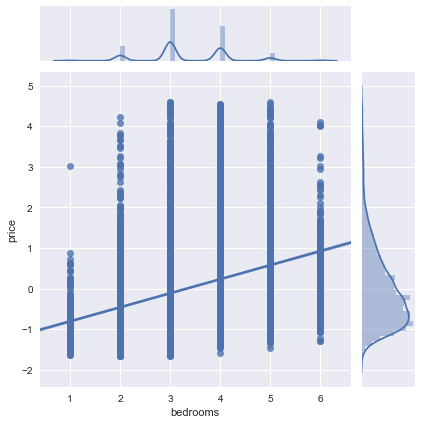

In [217]:
sns.jointplot('bedrooms', 'price', df, kind='reg')

Definite linearity.

### bathrooms +

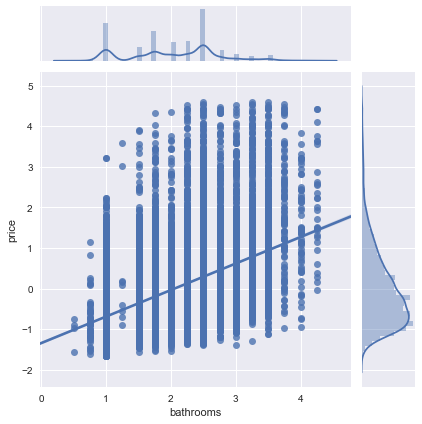

In [218]:
sns.jointplot('bathrooms', 'price', df, kind='reg')

Definite linearity.

### sqft_living +

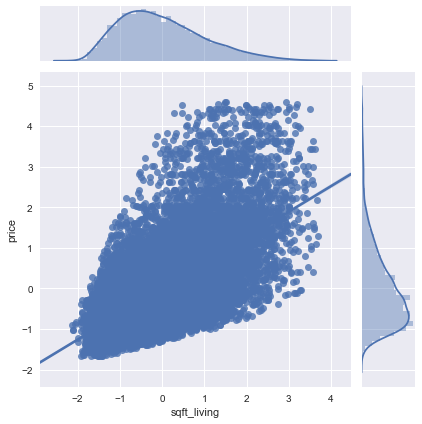

In [219]:
sns.jointplot('sqft_living', 'price', df, kind='reg')

Very linear.

### sqft_lot +

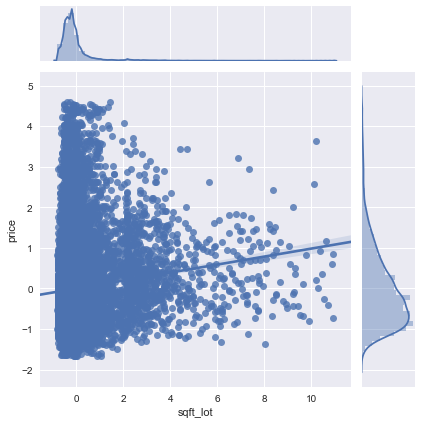

In [220]:
sns.jointplot('sqft_lot', 'price', df, kind='reg')

Some linearity.

### floors +

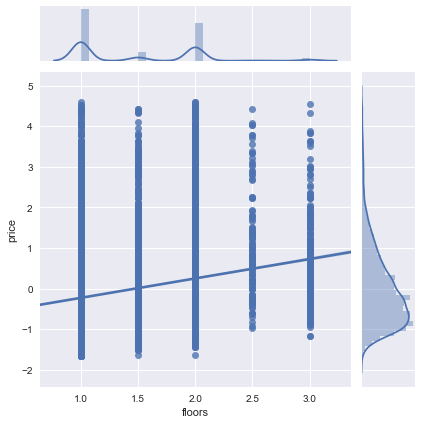

In [221]:
sns.jointplot('floors', 'price', df, kind='reg')

Some linearity.

### waterfront +

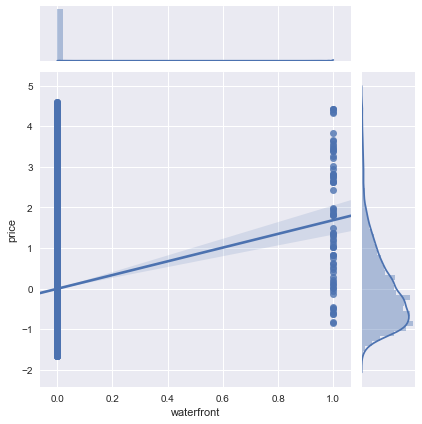

In [222]:
sns.jointplot('waterfront', 'price', df, kind='reg')

Fairly linear.

### condition

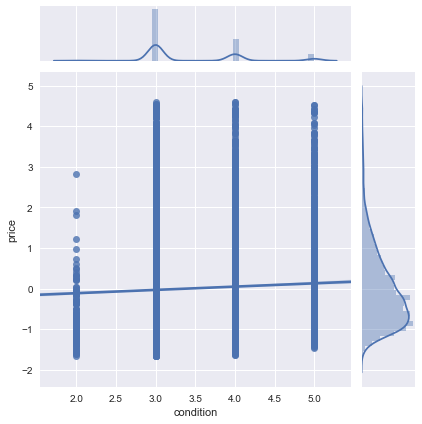

In [223]:
sns.jointplot('condition', 'price', df, kind='reg')

Not very linear.

### grade +

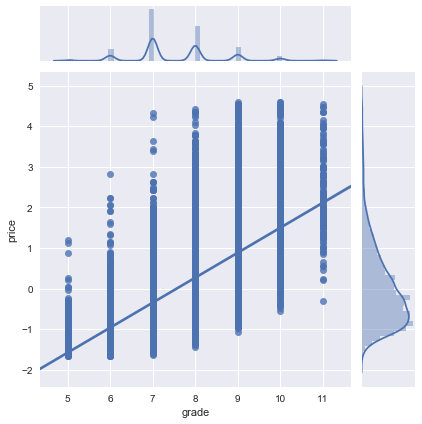

In [224]:
sns.jointplot('grade', 'price', df, kind='reg')

Definitely some linearity there.

### sqft_above +

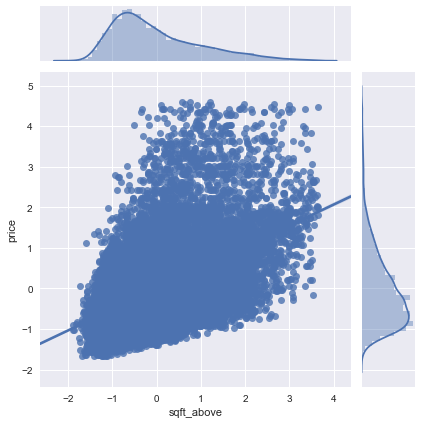

In [225]:
sns.jointplot('sqft_above', 'price', df, kind='reg')

That shows definite linearity.

### lat +

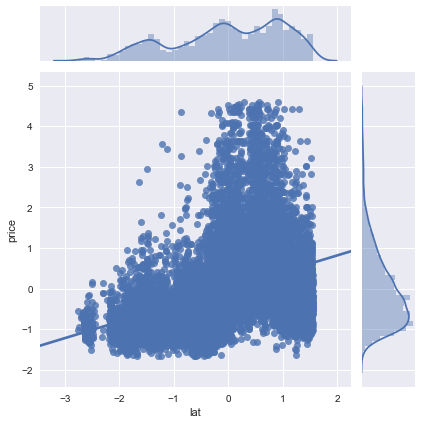

In [226]:
sns.jointplot('lat', 'price', df, kind='reg')

Good linearity.

### long

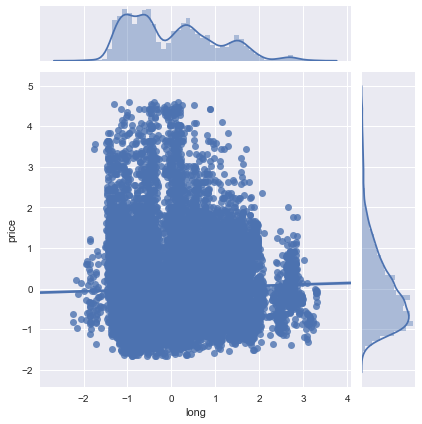

In [227]:
sns.jointplot('long', 'price', df, kind='reg')

Not so linear.

### sqft_living15 +

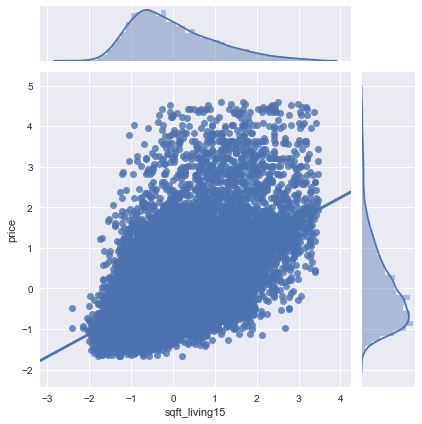

In [228]:
sns.jointplot('sqft_living15', 'price', df, kind='reg')

Definite linearity.

### sqft_lot15

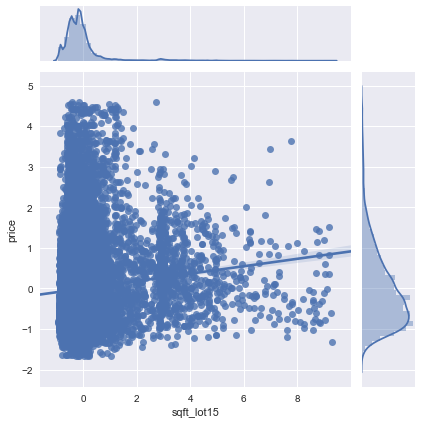

In [229]:
sns.jointplot('sqft_lot15', 'price', df, kind='reg')

Not much linearity.

### basement

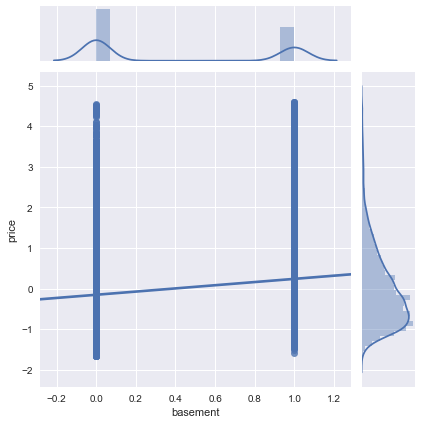

In [230]:
sns.jointplot('basement', 'price', df, kind='reg')

Not much linearity.

### renovated

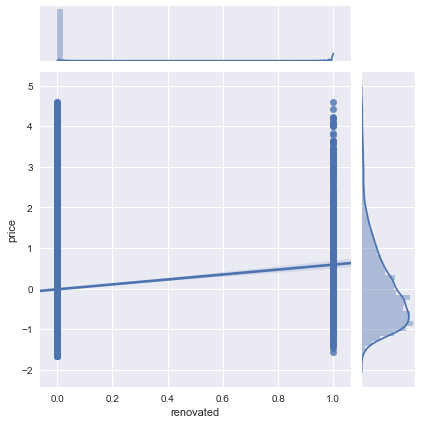

In [231]:
sns.jointplot('renovated', 'price', df, kind='reg')

Not much linearity.

### age

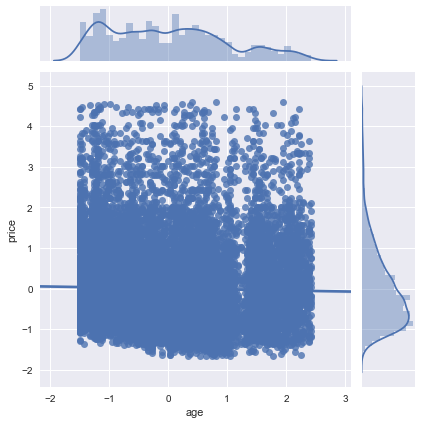

In [232]:
sns.jointplot('age', 'price', df, kind='reg')

Not much linearity.

## Check for multicollinearity

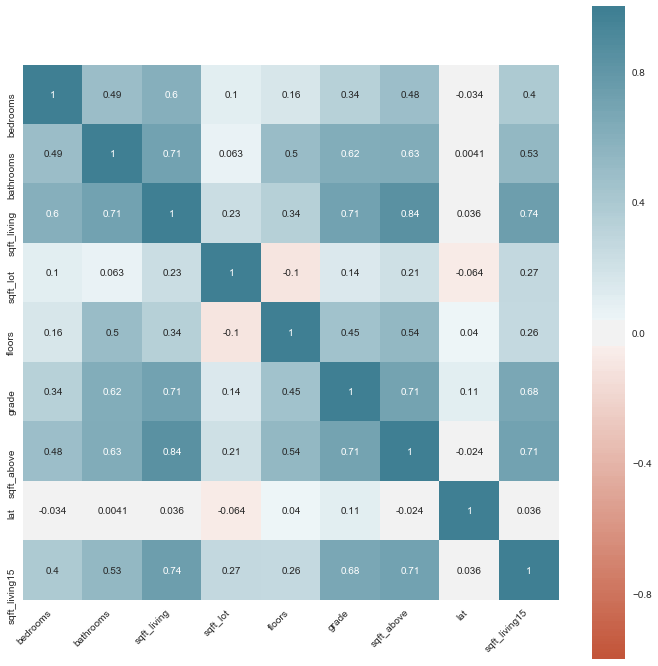

In [233]:
columns = ['bedrooms', 'bathrooms', 'sqft_living',
           'sqft_lot', 'floors', 'grade', 
           'sqft_above', 'lat', 'sqft_living15']

corr = df.loc[:, columns].corr()
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0,
                cmap=sns.diverging_palette(20, 220, n=200),
                square=True, annot=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylim(len(columns), 0)
plt.show()

# Model

## The original model.


In [234]:
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,...,renovated,age,reg_east_urban,reg_north,reg_north_and_seattle,reg_seattle,reg_south_and_seattle,reg_south_rural,reg_south_urban,reg_vashon_island
0,7129300520,-1.109967,3,1.00,-1.055900,-0.373287,1.0,0,3,7,...,0,0.511945,0,0,0,0,0,0,1,0
1,6414100192,0.161984,3,2.25,0.773261,-0.236586,2.0,0,3,7,...,1,0.648141,0,0,0,1,0,0,0,0
2,5631500400,-1.278567,2,1.00,-1.595437,0.000236,1.0,0,3,6,...,0,1.295068,0,1,0,0,0,0,0,0
3,2487200875,0.427561,4,3.00,-0.029464,-0.429100,1.0,0,5,7,...,0,0.171457,0,0,0,1,0,0,0,0
4,1954400510,0.049315,3,2.00,-0.397928,-0.164629,1.0,0,3,8,...,0,-0.543568,1,0,0,0,0,0,0,0


In [235]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [236]:
num_cols_pool = columns
removals = []
num_cols = [x for x in num_cols_pool if x not in removals]
cat_cols = region_cols + ['waterfront']
predictor_cols = num_cols + cat_cols
target = 'price'

In [237]:
print(predictor_cols)

['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade', 'sqft_above', 'lat', 'sqft_living15', 'reg_east_urban', 'reg_north', 'reg_north_and_seattle', 'reg_seattle', 'reg_south_and_seattle', 'reg_south_rural', 'reg_south_urban', 'reg_vashon_island', 'waterfront']


In [238]:
predictors = '+'.join(predictor_cols)
formula = f'{target}~{predictors}'
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     2650.
Date:                Wed, 19 Aug 2020   Prob (F-statistic):               0.00
Time:                        20:05:11   Log-Likelihood:                -16292.
No. Observations:               20099   AIC:                         3.262e+04
Df Residuals:                   20080   BIC:                         3.277e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.0142      0.054    -37.146      0.000      -2.120      -1.908
bedrooms                 -0.0243      0.006     -4.164      0.000      -0.036      -0.013
bathrooms                -0.0063      0.009     -0.691      0.489      -0.024       0.011
sqft_living               0.3656      0.010     36.391      0.000       0.346       0.385
sqft_lot                  0.0101      0.004      2.375      0.018       0.002       0.018
floors                   -0.1294      0.010    -12.351      0.000      -0.150      -0.109
grade                     0.2489      0.006     40.201      0.000       0.237       0.261
sqft_above                0.0163      0.009      1.749      0.080      -0.002       0.034
lat                       0.2240      0.008     28.111      0.000       0.208       0.240
sqft_living15             0.1455      0.007     22.355      0.000       0.133       0.158
reg_east_urban            0.5310      0.024     21.718      0.000       0.483       0.579
reg_north                -0.0932      0.029     -3.174      0.002      -0.151      -0.036
reg_north_and_seattle     0.1448      0.032      4.541      0.000       0.082       0.207
reg_seattle               0.8248      0.025     32.897      0.000       0.776       0.874
reg_south_and_seattle     0.3326      0.041      8.188      0.000       0.253       0.412
reg_south_rural           0.1716      0.034      5.034      0.000       0.105       0.238
reg_south_urban           0.0394      0.028      1.432      0.152      -0.015       0.093
reg_vashon_island         0.3427      0.069      4.946      0.000       0.207       0.478
waterfront                1.7364      0.066     26.195      0.000       1.606       1.866
==============================================================================
Omnibus:                     6139.452   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28192.618
Skew:                           1.424   Prob(JB):                         0.00
Kurtosis:                       8.055   Cond. No.                         188.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notes: Bathrooms and sqft_above are both above 0.05 p-value. We'll want to remove those, probably. Region_south_urban is also high, but because it's really just one part of the 'region' variable, we'll probably want to leave it in.

### VIF

In [239]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [240]:
X = df[num_cols]
X = add_constant(X)
X.head()

C:\Users\katma\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,lat,sqft_living15
0,1.0,3,1.00,-1.055900,-0.373287,1.0,7,-0.743153,-0.358509,-0.965318
1,1.0,3,2.25,0.773261,-0.236586,2.0,7,0.661010,1.148171,-0.390427
2,1.0,2,1.00,-1.595437,0.000236,1.0,6,-1.324676,1.269538,1.301394
3,1.0,4,3.00,-0.029464,-0.429100,1.0,7,-0.927538,-0.289567,-0.932467
4,1.0,3,2.00,-0.397928,-0.164629,1.0,8,-0.033980,0.399858,-0.209747


In [241]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(X.columns, vif))

[('const', 173.98617750702147),
 ('bedrooms', 1.6798165445674356),
 ('bathrooms', 2.626712622237532),
 ('sqft_living', 6.440177833034631),
 ('sqft_lot', 1.1530902580972662),
 ('floors', 2.0086434837336244),
 ('grade', 2.7172254117570867),
 ('sqft_above', 5.2829091531233345),
 ('lat', 1.0535809382050356),
 ('sqft_living15', 2.6918122336843755)]

(9, 0)

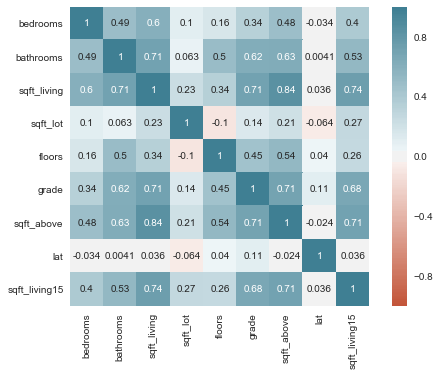

In [242]:
sns.heatmap(df[num_cols].corr(), vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True, annot=True)
plt.ylim(len(num_cols), 0)

Notes: High multicollinearity for sqft_living and sqft_above. We'll already be dropping sqft_above for its p-value, so this problem may correct itself.

### QQ Plot

In [243]:
import scipy.stats as stats

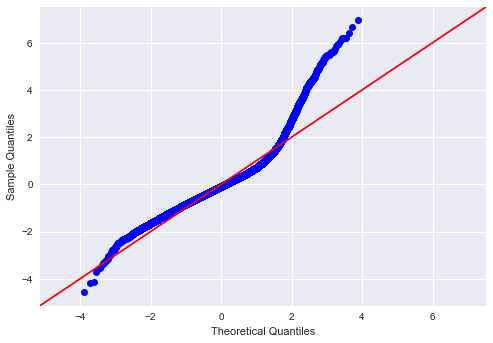

In [244]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

This plot is showing that the residual distribution is far from normal on the tails of our distribution.

## Refining the model

### First Refinement

We'll try to model this out again after removing our undesirable features.

In [247]:
num_cols_pool = columns
removals = ['bathrooms', 'sqft_above']
num_cols = [x for x in num_cols_pool if x not in removals]
cat_cols = region_cols + ['waterfront']
predictor_cols = num_cols + cat_cols
target = 'price'

In [248]:
predictors = '+'.join(predictor_cols)

formula = f'{target}~{predictors}'
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     2981.
Date:                Wed, 19 Aug 2020   Prob (F-statistic):               0.00
Time:                        20:12:29   Log-Likelihood:                -16294.
No. Observations:               20099   AIC:                         3.262e+04
Df Residuals:                   20082   BIC:                         3.276e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -2.0338      0.053    -38.102      0.000      -2.138      -1.929
bedrooms                 -0.0254      0.006     -4.396      0.000      -0.037      -0.014
sqft_living               0.3731      0.007     50.056      0.000       0.359       0.388
sqft_lot                  0.0108      0.004      2.551      0.011       0.003       0.019
floors                   -0.1227      0.008    -14.729      0.000      -0.139      -0.106
grade                     0.2494      0.006     41.081      0.000       0.237       0.261
lat                       0.2239      0.008     28.122      0.000       0.208       0.240
sqft_living15             0.1474      0.006     22.886      0.000       0.135       0.160
reg_east_urban            0.5292      0.024     21.685      0.000       0.481       0.577
reg_north                -0.0958      0.029     -3.270      0.001      -0.153      -0.038
reg_north_and_seattle     0.1412      0.032      4.452      0.000       0.079       0.203
reg_seattle               0.8182      0.025     33.253      0.000       0.770       0.866
reg_south_and_seattle     0.3312      0.041      8.174      0.000       0.252       0.411
reg_south_rural           0.1709      0.034      5.014      0.000       0.104       0.238
reg_south_urban           0.0377      0.027      1.375      0.169      -0.016       0.092
reg_vashon_island         0.3399      0.069      4.908      0.000       0.204       0.476
waterfront                1.7311      0.066     26.139      0.000       1.601       1.861
==============================================================================
Omnibus:                     6135.812   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28165.244
Skew:                           1.423   Prob(JB):                         0.00
Kurtosis:                       8.052   Cond. No.                         182.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This had no effect on our R-squared value and negligible effect on our adusted R-squared. With the exception of the south urban region which we discussed earlier, all features have an acceptable p-value.

#### VIF

In [249]:
X = df[num_cols]
X = add_constant(X)

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(X.columns, vif))

[('const', 166.42440704112803),
 ('bedrooms', 1.6333552975625845),
 ('sqft_living', 3.74217054930164),
 ('sqft_lot', 1.1348737619075357),
 ('floors', 1.3189663587551084),
 ('grade', 2.6285910366414593),
 ('lat', 1.0243144910564896),
 ('sqft_living15', 2.563673133489552)]

Our VIF values look good now.

#### QQ Plot

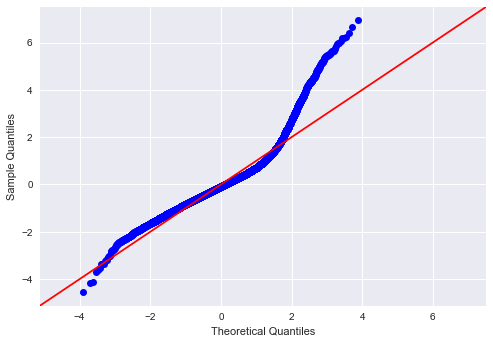

In [250]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

That's still way off on the positive tail. We might want to look into logarithms to smooth it out.

### Second Refinement

Let's take the log of our target variable, price, and see if that helps us out.

In [339]:
dfo = pd.read_pickle('non_norm_data.pkl')

In [340]:
dfo.price = np.log(dfo.price)

In [341]:
dfo = pd.concat([dfo, zip_dummies], axis=1)
dfo = dfo.drop(columns=['zipcode'])

In [342]:
removals = ['sqft_above', 'bathrooms', 'bedrooms', 'lat']
num_cols = [x for x in num_cols_pool if x not in removals]
cat_cols = region_cols + ['waterfront']
predictor_cols = num_cols + cat_cols
target = 'price'

In [343]:
predictors = '+'.join(predictor_cols)

formula = f'{target}~{predictors}'
model = ols(formula=formula, data=dfo).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     4424.
Date:                Wed, 19 Aug 2020   Prob (F-statistic):               0.00
Time:                        21:56:31   Log-Likelihood:                 616.07
No. Observations:               20099   AIC:                            -1202.
Df Residuals:                   20084   BIC:                            -1084.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                11.4766      0.017    674.611      0.000      11.443      11.510
sqft_living               0.0002   3.63e-06     59.611      0.000       0.000       0.000
sqft_lot               7.486e-07   1.57e-07      4.781      0.000    4.42e-07    1.06e-06
floors                   -0.0338      0.004     -9.422      0.000      -0.041      -0.027
grade                     0.1085      0.003     41.823      0.000       0.103       0.114
sqft_living15             0.0001   4.55e-06     25.475      0.000       0.000       0.000
reg_east_urban            0.2244      0.011     21.346      0.000       0.204       0.245
reg_north                 0.0622      0.012      5.133      0.000       0.038       0.086
reg_north_and_seattle     0.1418      0.013     10.646      0.000       0.116       0.168
reg_seattle               0.3596      0.011     33.911      0.000       0.339       0.380
reg_south_and_seattle    -0.0715      0.017     -4.143      0.000      -0.105      -0.038
reg_south_rural          -0.2221      0.013    -17.204      0.000      -0.247      -0.197
reg_south_urban          -0.2745      0.011    -26.053      0.000      -0.295      -0.254
reg_vashon_island         0.0170      0.029      0.579      0.563      -0.041       0.075
waterfront                0.6766      0.029     23.724      0.000       0.621       0.733
==============================================================================
Omnibus:                      710.699   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1918.876
Skew:                          -0.123   Prob(JB):                         0.00
Kurtosis:                       4.494   Cond. No.                     3.24e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.24e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### VIF

In [344]:
X = dfo[num_cols]
X = add_constant(X)

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(X.columns, vif))

C:\Users\katma\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


[('const', 68.31480066346727),
 ('sqft_living', 2.7571275183457096),
 ('sqft_lot', 1.1265094709073504),
 ('floors', 1.3175601206619445),
 ('grade', 2.549413702095465),
 ('sqft_living15', 2.559255635264573)]

The model summary warns of a high condition number, but the VIF values are acceptable.

#### QQ Plot

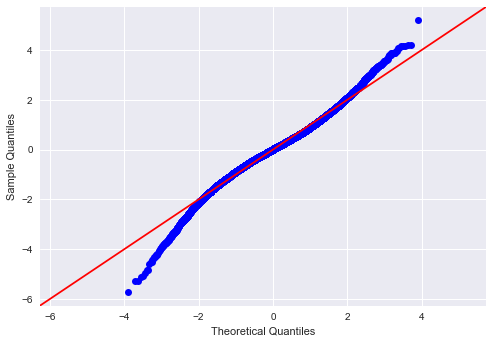

In [345]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

Definitely seemed to help on the high end, but the low end is farther off than before.

### Third Refinement

Let's try taking the log of all continious numeric independent variables.

In [346]:
dfo = pd.read_pickle('non_norm_data.pkl')

In [347]:
log_cols = ['sqft_living', 'sqft_lot', 'sqft_living15']

In [348]:
dfo[log_cols] = np.log(dfo[log_cols])
dfo.price = np.log(dfo.price)

In [349]:
dfo = pd.concat([dfo, zip_dummies], axis=1)
dfo = dfo.drop(columns=['zipcode'])

In [350]:
dfo.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,...,renovated,age,reg_east_urban,reg_north,reg_north_and_seattle,reg_seattle,reg_south_and_seattle,reg_south_rural,reg_south_urban,reg_vashon_island
0,7129300520,12.309982,3,1.00,7.073270,8.639411,1.0,0,3,7,...,0,59,0,0,0,0,0,0,1,0
1,6414100192,13.195614,3,2.25,7.851661,8.887653,2.0,0,3,7,...,1,63,0,0,0,1,0,0,0,0
2,5631500400,12.100712,2,1.00,6.646391,9.210340,1.0,0,3,6,...,0,82,0,1,0,0,0,0,0,0
3,2487200875,13.311329,4,3.00,7.580700,8.517193,1.0,0,5,7,...,0,49,0,0,0,1,0,0,0,0
4,1954400510,13.142166,3,2.00,7.426549,8.997147,1.0,0,3,8,...,0,28,1,0,0,0,0,0,0,0


In [351]:
removals = removals
num_cols = [x for x in num_cols_pool if x not in removals]
cat_cols = region_cols + ['waterfront']
predictor_cols = num_cols + cat_cols
target = 'price'

In [352]:
predictors = '+'.join(predictor_cols)

formula = f'{target}~{predictors}'
model = ols(formula=formula, data=dfo).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     4576.
Date:                Wed, 19 Aug 2020   Prob (F-statistic):               0.00
Time:                        21:57:17   Log-Likelihood:                 873.72
No. Observations:               20099   AIC:                            -1717.
Df Residuals:                   20084   BIC:                            -1599.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.0034      0.053    132.072      0.000       6.899       7.107
sqft_living               0.3982      0.007     57.827      0.000       0.385       0.412
sqft_lot                  0.0277      0.003      9.322      0.000       0.022       0.034
floors                   -0.0245      0.004     -6.235      0.000      -0.032      -0.017
grade                     0.1117      0.003     44.665      0.000       0.107       0.117
sqft_living15             0.2458      0.009     28.358      0.000       0.229       0.263
reg_east_urban            0.2277      0.010     21.943      0.000       0.207       0.248
reg_north                 0.0584      0.012      4.879      0.000       0.035       0.082
reg_north_and_seattle     0.1499      0.013     11.390      0.000       0.124       0.176
reg_seattle               0.3828      0.011     36.054      0.000       0.362       0.404
reg_south_and_seattle    -0.0504      0.017     -2.959      0.003      -0.084      -0.017
reg_south_rural          -0.2286      0.013    -17.945      0.000      -0.254      -0.204
reg_south_urban          -0.2757      0.010    -26.534      0.000      -0.296      -0.255
reg_vashon_island         0.0142      0.029      0.489      0.625      -0.043       0.071
waterfront                0.6681      0.028     23.719      0.000       0.613       0.723
==============================================================================
Omnibus:                      653.768   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1774.508
Skew:                          -0.073   Prob(JB):                         0.00
Kurtosis:                       4.448   Cond. No.                         529.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Values look good here.

#### VIF

In [353]:
X = dfo[num_cols]
X = add_constant(X)

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(X.columns, vif))

C:\Users\katma\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


[('const', 788.34423562465),
 ('sqft_living', 2.727052287150712),
 ('sqft_lot', 1.5245957207890644),
 ('floors', 1.6170848029226021),
 ('grade', 2.4245460191944894),
 ('sqft_living15', 2.531849996073097)]

Everything looks good here.

#### QQ Plot

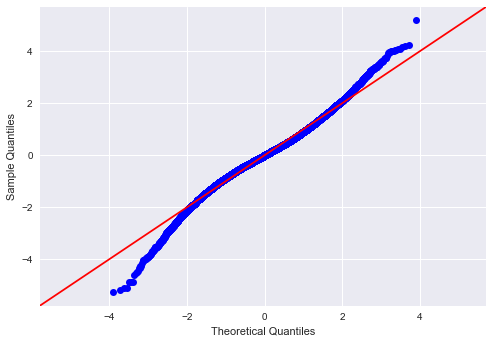

In [354]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

Not perfect, but it's a little better than before.

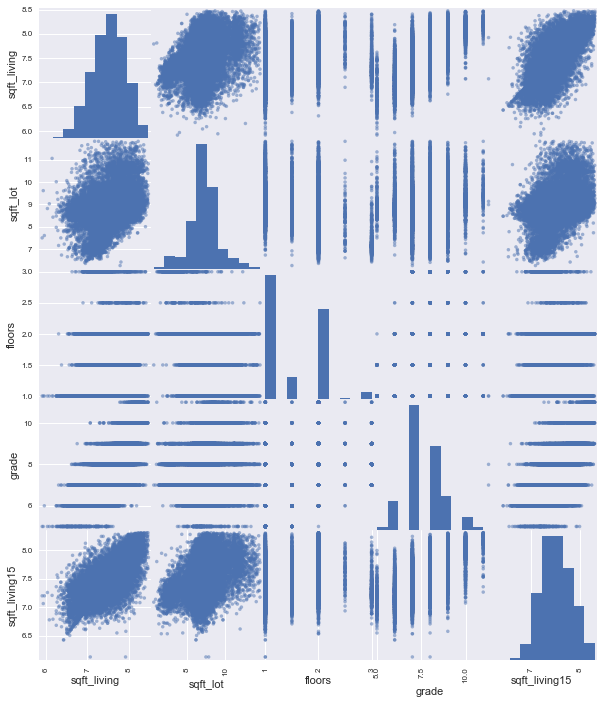

In [355]:
pd.plotting.scatter_matrix(dfo[num_cols], figsize=(10,12));

## Train-Test Split

In [356]:
from sklearn.model_selection import train_test_split
X = dfo[predictor_cols]
y = dfo.price

In [357]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

16079 4020
16079 4020


In [358]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
linreg = LinearRegression()
linreg.fit(X_train, y_train)
# find train and test values
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)
# find residuals
train_res = y_hat_train - y_train
test_res = y_hat_test - y_test
# find mean squared error
mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test, y_hat_test)

print('Train MSE:', mse_train)
print('Test MSE:', mse_test)

Train MSE: 0.05403209814154706
Test MSE: 0.05227591455983692


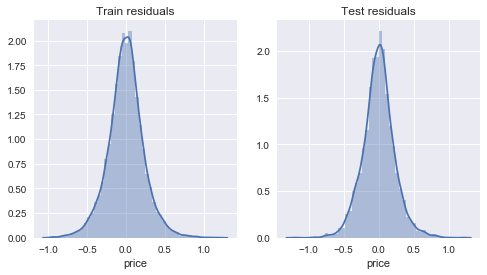

In [359]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
sns.distplot(train_res, ax=ax[0])
ax[0].set_title('Train residuals')
sns.distplot(test_res, ax=ax[1])
ax[1].set_title('Test residuals')
plt.show()

# iNterpret

In [360]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     4576.
Date:                Wed, 19 Aug 2020   Prob (F-statistic):               0.00
Time:                        21:57:54   Log-Likelihood:                 873.72
No. Observations:               20099   AIC:                            -1717.
Df Residuals:                   20084   BIC:                            -1599.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.0034      0.053    132.072      0.000       6.899       7.107
sqft_living               0.3982      0.007     57.827      0.000       0.385       0.412
sqft_lot                  0.0277      0.003      9.322      0.000       0.022       0.034
floors                   -0.0245      0.004     -6.235      0.000      -0.032      -0.017
grade                     0.1117      0.003     44.665      0.000       0.107       0.117
sqft_living15             0.2458      0.009     28.358      0.000       0.229       0.263
reg_east_urban            0.2277      0.010     21.943      0.000       0.207       0.248
reg_north                 0.0584      0.012      4.879      0.000       0.035       0.082
reg_north_and_seattle     0.1499      0.013     11.390      0.000       0.124       0.176
reg_seattle               0.3828      0.011     36.054      0.000       0.362       0.404
reg_south_and_seattle    -0.0504      0.017     -2.959      0.003      -0.084      -0.017
reg_south_rural          -0.2286      0.013    -17.945      0.000      -0.254      -0.204
reg_south_urban          -0.2757      0.010    -26.534      0.000      -0.296      -0.255
reg_vashon_island         0.0142      0.029      0.489      0.625      -0.043       0.071
waterfront                0.6681      0.028     23.719      0.000       0.613       0.723
==============================================================================
Omnibus:                      653.768   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1774.508
Skew:                          -0.073   Prob(JB):                         0.00
Kurtosis:                       4.448   Cond. No.                         529.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [361]:
# waterfront
(np.exp(0.6681) - 1) * 100

95.05277948921369

In [362]:
# floors
(np.exp(-0.0245) - 1) * 100

-2.4202311081592653

In [363]:
# grade
(np.exp(0.1117) - 1) * 100

11.81773571148974

## Evaluation

Our final model ended up with an R-squared of 0.761, which is a little higher than our original model despite having fewer features. All multicollinearity issues have been addressed, and though the kurtosis is slightly higher than ideal at 4.448, it is much better than the original model's 8.055.

We did use the log function on our continuous numerical features and the target, so those coefficients will be in terms of percentages rather than true values. We did not apply the log function to 'floors' or 'grade,' so those coefficients will be in terms of absolute increase in feature to percent increase in price.

Unsurprisingly, homes built on the waterfront tend to be more valuable than those that are not. Since the target (price) has been log transformed, and waterfront variable has not, we must interpret the coefficient of 0.6681 as (np.exp(0.6681) - 1) * 100. This tells us that a house on the waterfront can be expected to have a price about 95% higher than a similar house that is not on the waterfront.

We apply that same logic to 'floors' and 'grade' to find that for each incremental increase in 'floors' the expected value of the home decreases by about 2.4%. An incremental increase in grade leads to an expected value increase of 11.8%

As for the continuous numerical variables, the square footage of the home shows the most effect, with a 1% increase in square footage adding an expected 0.4% increase in price. The variable 'sqft_living15' is the square footage of a homes 15 nearest neighbors, and a 1% increase shows an expected 0.25% increase in a home's price. Lastly, the square footage of a home's lot has a coefficient of 0.1117, meaning that a 1% increase in lot size amounts to an expected 0.11% increase in price. 

As for location, the Seattle and East Urban regions tend to have the highest positive influence on price. South Urban and South Rural homes tend to be the most negatively influenced.